In [1]:
import itertools
from multiprocessing import Pool
import warnings

class World(object):
    def __init__(self, light, contains=list()):
        self.light = light
        self.contains = contains

def world():
    """
    >>> w = world()
    >>> w.light is None and len(w.contains) == 0
    True
    """
    return World(None)
    
def default_world():
    """
    >>> light = point_light(point(-10, 10, -10), color(1,1,1))
    >>> s1 = sphere()
    >>> s1.material.color = color(0.8,1.0,0.6)
    >>> s1.material.diffuse = 0.7
    >>> s1.material.specular = 0.2
    >>> s2 = sphere()
    >>> s2.transform = scaling(0.5,0.5,0.5)
    >>> w = default_world()
    >>> w.light.position == light.position
    array([ True,  True,  True,  True])

    >>> w.light.intensity == light.intensity
    array([ True,  True,  True])
    >>> len(w.contains) == 2
    True
    >>> w.contains[0].material.color == color(0.8,1.0,0.6)  
    array([ True,  True,  True])
    >>> w.contains[0].material.diffuse == 0.7 and w.contains[0].material.specular == 0.2
    True
    >>> w.contains[1].transform == scaling(0.5,0.5,0.5)
    array([[ True,  True,  True,  True],
           [ True,  True,  True,  True],
           [ True,  True,  True,  True],
           [ True,  True,  True,  True]])
    """
    light = point_light(point(-10, 10, -10), color(1,1,1))
    s1 = sphere()
    s1.material.color = color(0.8,1.0,0.6)
    s1.material.diffuse = 0.7
    s1.material.specular = 0.2
    s2 = sphere()
    s2.transform = scaling(0.5,0.5,0.5)
    return World(light, [s1,s2])

def intersect_world(world, r):
    """
    >>> w = default_world()
    >>> r = ray(point(0,0,-5), vector(0,0,1))
    >>> xs = intersect_world(w, r)
    >>> len(xs) == 4 and xs[0].t == 4 and xs[1].t == 4.5 and xs[2].t == 5.5 and xs[3].t == 6
    True
    """
    xs = []
    for obj in world.contains:
        xs.extend(intersect(obj, r))
    return intersections(*xs)

class Computations(object):
    def __init__(self, t, obj, point, eyev, normalv, inside):
        self.t = t
        self.object = obj
        self.point = point
        self.eyev = eyev
        self.normalv = normalv
        self.inside = inside
        
def prepare_computations(intersection, r):
    """
    >>> r = ray(point(0,0,-5), vector(0,0,1))
    >>> shape = sphere()
    >>> i = intersection(4, shape)
    >>> comps = prepare_computations(i, r)
    >>> comps.t == i.t
    True
    >>> comps.object == i.object
    True
    >>> comps.point == point(0,0,-1)
    array([ True,  True,  True,  True])

    >>> comps.eyev == vector(0,0,-1)
    array([ True,  True,  True,  True])

    >>> comps.normalv == vector(0,0,-1)
    array([ True,  True,  True,  True])

    >>> r = ray(point(0,0,-5), vector(0,0,1))
    >>> shape = sphere()
    >>> i = intersection(4, shape)
    >>> comps = prepare_computations(i, r)
    >>> comps.inside
    False

    >>> r = ray(point(0,0,0), vector(0,0,1))
    >>> shape = sphere()
    >>> i = intersection(1, shape)
    >>> comps = prepare_computations(i, r)
    >>> comps.inside
    True
    >>> comps.point == point(0,0,1)
    array([ True,  True,  True,  True])

    >>> comps.eyev == vector(0,0,-1)
    array([ True,  True,  True,  True])

    >>> comps.normalv == vector(0,0,-1)
    array([ True,  True,  True,  True])
    """
    p = position(r, intersection.t)

    c = Computations(intersection.t,
                    intersection.object,
                    p,
                    -r.direction,
                    normal_at(intersection.object, p),
                    False)

    if dot(c.normalv, c.eyev) < 0:
        c.inside = True
        c.normalv = -c.normalv

    return c

def shade_hit(world, comps):
    """
    >>> w = default_world()
    >>> r = ray(point(0,0,-5), vector(0,0,1))
    >>> shape = w.contains[0]
    >>> i = intersection(4, shape)
    >>> comps = prepare_computations(i, r)
    >>> c = shade_hit(w, comps)
    >>> np.isclose(c,color(0.38066, 0.47583, 0.28549589))
    array([ True,  True,  True])

    >>> w = default_world()
    >>> w.light = point_light(point(0,0.25,0), color(1,1,1))
    >>> r = ray(point(0,0,0), vector(0,0,1))
    >>> shape = w.contains[1]
    >>> i = intersection(0.5, shape)
    >>> comps = prepare_computations(i,r)
    >>> c = shade_hit(w, comps)
    >>> np.isclose(c,color(0.90498, 0.90498, 0.90498))
    array([ True,  True,  True])
    """
    # TODO iterate over all lighting sources in world, call lighting(), and return the sum of the colors
    return lighting(comps.object.material,
                    world.light,
                    comps.point,
                    comps.eyev,
                    comps.normalv)

def color_at(world, ray):
    """
    >>> w = default_world()
    >>> r = ray(point(0,0,-5), vector(0,1,0))
    >>> c = color_at(w,r)
    >>> np.isclose(c, color(0,0,0))
    array([ True,  True,  True])

    >>> w = default_world()
    >>> r = ray(point(0,0,-5), vector(0,0,1))
    >>> c = color_at(w,r)
    >>> np.isclose(c, color(0.38066, 0.47583, 0.28549589))
    array([ True,  True,  True])

    >>> w = default_world()
    >>> outer = w.contains[0]
    >>> outer.material.ambient = 1.0
    >>> inner = w.contains[1]
    >>> inner.material.ambient = 1.0
    >>> r = ray(point(0,0,0.75), vector(0,0,-1))
    >>> c = color_at(w,r)
    >>> c == inner.material.color
    array([ True,  True,  True])
    """
    xs = intersect_world(world, ray)
    i = hit(xs)
    if i is None:
        return black
    comps = prepare_computations(i,ray)
    return shade_hit(world, comps)


def view_transform(fr, to, up):
    """
    >>> fr = point(0,0,0)
    >>> to = point(0,0,-1)
    >>> up = vector(0,1,0)
    >>> t = view_transform(fr, to, up)
    >>> t == matrix4x4identity()
    array([[ True,  True,  True,  True],
           [ True,  True,  True,  True],
           [ True,  True,  True,  True],
           [ True,  True,  True,  True]])

    >>> fr = point(0,0,0)
    >>> to = point(0,0,1)
    >>> up = vector(0,1,0)
    >>> t = view_transform(fr, to, up)
    >>> t == scaling(-1,1,-1)
    array([[ True,  True,  True,  True],
           [ True,  True,  True,  True],
           [ True,  True,  True,  True],
           [ True,  True,  True,  True]])

    >>> fr = point(0,0,8)
    >>> to = point(0,0,0)
    >>> up = vector(0,1,0)
    >>> t = view_transform(fr, to, up)
    >>> t == translation(0,0,-8)
    array([[ True,  True,  True,  True],
           [ True,  True,  True,  True],
           [ True,  True,  True,  True],
           [ True,  True,  True,  True]])

    >>> fr = point(1,3,2)
    >>> to = point(4,-2,8)
    >>> up = vector(1,1,0)
    >>> t = view_transform(fr, to, up)
    >>> t
    array([[-0.50709255,  0.50709255,  0.6761234 , -2.36643191],
           [ 0.76771593,  0.60609153,  0.12121831, -2.82842712],
           [-0.35856858,  0.5976143 , -0.71713717,  0.        ],
           [ 0.        ,  0.        ,  0.        ,  1.        ]])

    """
    forward = normalize(to - fr)
    upn = normalize(up)
    left = cross(forward, upn)
    true_up = cross(left, forward)
    orientation = matrix(left[0], left[1], left[2], 0,
                         true_up[0], true_up[1], true_up[2], 0,
                         -forward[0], -forward[1], -forward[2], 0,
                         0,0,0,1)
    return matrix_multiply(orientation, translation(-fr[0], -fr[1], -fr[2]))

class Camera(object):
    def __init__(self, hsize, vsize, field_of_view, transform=matrix4x4identity()):
        self.hsize = hsize
        self.vsize = vsize
        self.field_of_view = field_of_view
        self.transform = transform
        self.half_width, self.half_height, self.pixel_size = self._compute_sizes()

    def _compute_sizes(self):
        half_view = np.tan(self.field_of_view / 2)
        aspect = float(self.hsize) / float(self.vsize)
        if aspect >= 1:
            half_width = half_view
            half_height = half_view / aspect
        else:
            half_width = half_view * aspect
            half_height = half_view
        return half_width, half_height, half_width * 2 / self.hsize

def camera(hsize, vsize, field_of_view):
    """
    >>> hsize = 160
    >>> vsize = 120
    >>> field_of_view = np.pi / 2
    >>> c = camera(hsize, vsize, field_of_view)
    >>> c.hsize == 160 and c.vsize == 120 and c.field_of_view == np.pi / 2
    True
    >>> c.transform == matrix4x4identity()
    array([[ True,  True,  True,  True],
           [ True,  True,  True,  True],
           [ True,  True,  True,  True],
           [ True,  True,  True,  True]])

    >>> c = camera(200, 125, np.pi / 2)    
    >>> np.isclose(c.pixel_size, 0.01)
    True

    >>> c = camera(125, 200, np.pi / 2)
    >>> np.isclose(c.pixel_size,0.01)
    True
    """
    return Camera(hsize, vsize, field_of_view)

def ray_for_pixel(cam, px, py):
    """
    >>> c = camera(201, 101, np.pi/2)
    >>> r = ray_for_pixel(c, 100, 50)
    >>> r.origin == point(0,0,0)
    array([ True,  True,  True,  True])

    >>> np.isclose(r.direction, vector(0,0,-1))
    array([ True,  True,  True,  True])

    >>> c = camera(201, 101, np.pi/2)
    >>> r = ray_for_pixel(c, 0, 0)
    >>> r.origin == point(0,0,0)
    array([ True,  True,  True,  True])

    >>> np.isclose(r.direction, vector(0.66519, 0.33259, -0.66851))
    array([ True,  True,  True,  True])

    >>> c = camera(201, 101, np.pi/2)
    >>> c.transform = matrix_multiply(rotation_y(np.pi/4), translation(0,-2,5))
    >>> r = ray_for_pixel(c, 100, 50)
    >>> np.isclose(r.origin, point(0,2,-5))
    array([ True,  True,  True,  True])

    >>> np.isclose(r.direction, vector(np.sqrt(2)/2, 0, -np.sqrt(2)/2))
    array([ True,  True,  True,  True])
    """
    xoffset = (px + 0.5) * cam.pixel_size
    yoffset = (py + 0.5) * cam.pixel_size
    world_x = cam.half_width - xoffset
    world_y = cam.half_height - yoffset

    pixel = matrix_multiply(inverse(cam.transform), point(world_x, world_y, -1))
    origin = matrix_multiply(inverse(cam.transform), point(0,0,0))
    direction = normalize(pixel - origin)

    return ray(origin, direction)

# TODO https://jonasteuwen.github.io/numpy/python/multiprocessing/2017/01/07/multiprocessing-numpy-array.html
# Pool size 4 on raspberry pi 3b+
def render(cam, world):
    """
    >>> w = default_world()
    >>> c = camera(11, 11, np.pi/2)
    >>> fr = point(0,0,-5)
    >>> to = point(0,0,0)
    >>> up = vector(0,1,0)
    >>> c.transform = view_transform(fr, to, up)
    >>> image = render(c,w)
    >>> np.isclose(pixel_at(image, 5, 5), color(0.38066119, 0.47582649, 0.28549589))
    array([ True,  True,  True])
    """
    image = canvas(cam.hsize, cam.vsize)
    for y in range(cam.vsize):
        for x in range(cam.hsize):
            r = ray_for_pixel(cam, x, y)
            c = color_at(world, r)
            write_pixel(image, x, y, c)

    return image

block_size=4
def render_multi_helper(args):
    cam, world, window_x, window_y = args

    for idx_x in range(window_x, window_x + block_size):
        for idx_y in range(window_y, window_y + block_size):
            r = ray_for_pixel(cam, idx_x, idx_y)
            c = color_at(world, r)
            write_pixel(image, idx_x, idx_y, c)

def render_multi(cam, world, num_threads=4):
    """
    >>> w = default_world()
    >>> c = camera(11, 11, np.pi/2)
    >>> fr = point(0,0,-5)
    >>> to = point(0,0,0)
    >>> up = vector(0,1,0)
    >>> c.transform = view_transform(fr, to, up)
    >>> image = render_multi(c,w)
    >>> np.isclose(pixel_at(image, 5, 5), color(0.38066119, 0.47582649, 0.28549589))
    array([ True,  True,  True])
    """
    global image
    image = canvas(cam.hsize, cam.vsize)
    window_idxs = [(cam, world, i, j) for i, j in
                   itertools.product(range(0, cam.hsize, block_size),
                                     range(0, cam.vsize, block_size))]

    p = Pool(num_threads)
    _ = p.map(render_multi_helper, window_idxs)
    p.close()
    p.join()
    return np.ctypeslib.as_array(image.shared_arr)

canvas construction start at 2019-08-28 20:25:36.523950+00:00
canvas constructed in 14.043602 seconds.
ppm constructed
ppm file written


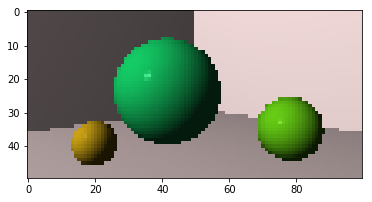

In [2]:
world = default_world()
world.contains = []
world.light_source = point_light(point(-10, 10, -10), color(1, 1, 1))

floor = sphere()
floor.transform = scaling(10,0.01,10)
floor.material = material()
floor.material.color = color(1, 0.9, 0.9)
floor.material.specular = 0

left_wall = sphere()
left_wall.transform = matrix_multiply(translation(0, 0, 5),
                                      matrix_multiply(rotation_y(-np.pi/4),
                                                      matrix_multiply(rotation_x(np.pi/2),scaling(10, 0.01, 10))))
left_wall.material = floor.material

right_wall = sphere()
right_wall.transform = matrix_multiply(translation(0, 0, 5),
                                       matrix_multiply(rotation_y(np.pi/4),
                                                       matrix_multiply(rotation_x(np.pi/2),scaling(10, 0.01, 10))))
right_wall.material = floor.material

middle = sphere()
middle.transform = translation(-0.5, 1, 0.5)
middle.material = material()
middle.material.color = color(0.1, 1, 0.5)
middle.material.diffuse = 0.7
middle.material.specular = 0.3

right = sphere()
right.transform = matrix_multiply(translation(1.5, 0.5, -0.5), scaling(0.5, 0.5, 0.5))
right.material = material()
right.material.color = color(0.5, 1, 0.1)
right.material.diffuse = 0.7
right.material.specular = 0.3

left = sphere()
left.transform = matrix_multiply(translation(-1.5, 0.33, -0.75), scaling(0.33, 0.33, 0.33))
left.material = material()
left.material.color = color(1, 0.8, 0.1)
left.material.diffuse = 0.7
left.material.specular = 0.3

world.contains.extend([floor, left_wall, right_wall, middle, right, left])

cam = camera(100, 50, np.pi/3)
cam.transform = view_transform(point(0, 1.5, -5),
                               point(0, 1, 0),
                               vector(0, 1, 0))



from datetime import datetime, timezone, timedelta
now = datetime.now(timezone.utc)
epoch = datetime(1970, 1, 1, tzinfo=timezone.utc) # use POSIX epoch
posix_timestamp_micros_before = (now - epoch) / timedelta(microseconds=1)

print('canvas construction start at {}'.format(now))
# render the result to a canvas.
ca = render_multi(cam, world)


now = datetime.now(timezone.utc)
epoch = datetime(1970, 1, 1, tzinfo=timezone.utc) # use POSIX epoch
posix_timestamp_micros_after = (now - epoch) / timedelta(microseconds=1)
delta = posix_timestamp_micros_after - posix_timestamp_micros_before
print('canvas constructed in {} seconds.'.format(delta/1000000))


ppm = construct_ppm(ca)
print('ppm constructed')

with open('./chapter7scene.ppm', 'wb') as f:
    f.write(ppm)
print('ppm file written')

import PIL.Image as Image
from matplotlib.pyplot import imshow

%matplotlib inline
im = Image.open('./chapter7scene.ppm', 'r')
im.save('./chapter7scene.jpg')
imshow(im)